<a href="https://colab.research.google.com/github/anniebritton/Eco-Drought-South-Dakota/blob/main/NDVI_Data_Acquisition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Colab Set Up**

In [ ]:
# installs and import libraries
!pip install earthengine-api --upgrade
!pip install geemap
!pip install geopandas 
!pip install matplotlib

import ee
import geemap.foliumap as geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

In [ ]:
# initialise ee, copy and paste the authentication code
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

In [ ]:
# mount gogole drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import and create a variable for the shapefile
AOI_path = '/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/Shapefiles/Cheyenne_Basin/Cheyenne_Basin_whole.shp'

# convert the shapefile into an Earth Engine object
AOI = geemap.shp_to_ee(AOI_path)

**Setting up the masking and preprocessing for the MODIS NDVI Data**

In [ ]:
# First, a function to mask out cloudy pixels
def mask_clouds(image):
    # Select the QA band
    QA = image.select('state_1km')
    # Make a mask to get bit 10, the internal cloud algorithm flag bit
    bit_mask = 1 << 10
    # Return an image masking out cloudy areas
    return image.updateMask(QA.bitwiseAnd(bit_mask).eq(0))


# Next, a function to mask out pixels with snow
def mask_snow(image):
    # Select the QA band
    QA = image.select('state_1km')
    # Make a mask to get bit 15, the internal snow mask bit
    bit_mask = 1 << 15
    # Return an image masking out snowy areas
    return image.updateMask(QA.bitwiseAnd(bit_mask).eq(0))


# Get MODIS surface reflectance image collection
mod09ga = ee.ImageCollection("MODIS/006/MOD09GA")

# Filter image collections by date and apply the mask_clouds and mask_snow functions
mod09ga_masked = mod09ga.filterDate('2000-02-24', '2021-12-31').map(mask_clouds).map(mask_snow)

In [ ]:
# Next, a function to calculate and create a new NDVI band
def get_NDVI(imagecol):
    ndvi = imagecol.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename("NDVI")
    return imagecol.addBands(ndvi).select('NDVI').copyProperties(imagecol)

# Add NDVI as a band to the image
mod09ga_NDVI = mod09ga_masked.map(get_NDVI)

**Data Set Up**

In [ ]:
# MODIS NDVI
NDVI_list = [mod09ga_NDVI, 'NDVI', AOI, 1000 ]

# Daymet
swe_list = [ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate('2000-02-24','2021-12-31'), 'swe', AOI, 1000]

# gridMET Meteorology
tmin_list = [ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('2000-02-24','2021-12-31'), 'tmmn', AOI, 4638.3]
tmax_list = [ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('2000-02-24','2021-12-31'), 'tmmx', AOI, 4638.3]
precip_list = [ee.ImageCollection("IDAHO_EPSCOR/GRIDMET").filterDate('2000-02-24','2021-12-31'), 'pr', AOI, 4638.3]

# gridMET Drought
pdsi_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'pdsi', AOI, 4638.3]
palmerz_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'z', AOI, 4638.3]

spei30_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'spei30d', AOI, 4638.3]
spei90_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'spei90d', AOI, 4638.3]
spei180_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'spei180d', AOI, 4638.3]

spi30_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'spi30d', AOI, 4638.3]
spi90_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'spi90d', AOI, 4638.3]
spi180_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'spi180d', AOI, 4638.3]

eddi30_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'eddi30d', AOI, 4638.3]
eddi90_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'eddi90d', AOI, 4638.3]
eddi180_list = [ee.ImageCollection("GRIDMET/DROUGHT").filterDate('2000-02-24','2021-12-31'), 'eddi180d', AOI, 4638.3]

**Function for Creating a Timeseries of Spatially Averaged Data**

In [ ]:
def spatialtimeseries(datalist):
  
    data = datalist[0]
    band = datalist[1]
    geometry = datalist[2]
    scale = datalist[3]

    # reduce the image collection to the area of study and to the correct bands
    def aoi_mean(img):
        mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=geometry, scale=scale).get(band)
        return img.set('date', img.date().format()).set('mean', mean)

    # Map this function to every image in our collection to get a new 
    # ImageCollection, but now each image has the mean value for the region of interest and the date. 
    aoi_reduced_imgs = data.map(aoi_mean)

    # Reduce the images to a list of lists:
    # for each image, we have a 2-element list that contains that images date and mean value (for our point of interest)
    # each of these lists are themselves elements in our outer list, which is what we’ll convert to a dataframe
    nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

    # This nested list can be turned into a dataframe using the .DataFrame constructor.
    # Call the callback method "getInfo" to retrieve the data
    df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

    # Set the date column to be the index.
    df['date'] = pd.to_datetime(df['date']).dt.date
    df = df.set_index('date')

    return(df)

**Run the Function Across the Data**

In [ ]:
# NDVI
NDVI_df = spatialtimeseries(NDVI_list)

In [ ]:
# Daymet
swe_df = spatialtimeseries(swe_list)

In [ ]:
# gridMET Meteorology
tmin_df = spatialtimeseries(tmin_list)
tmax_df = spatialtimeseries(tmax_list)
precip_df = spatialtimeseries(precip_list)

In [ ]:
# gridMET Drought
pdsi_df = spatialtimeseries(pdsi_list)
palmerz_df = spatialtimeseries(palmerz_list)

In [ ]:
eddi30_df = spatialtimeseries(eddi30_list)
eddi90_df = spatialtimeseries(eddi90_list)
eddi180_df = spatialtimeseries(eddi180_list)

In [ ]:
spei30_df = spatialtimeseries(spei30_list)
spei90_df = spatialtimeseries(spei90_list)
spei180_df = spatialtimeseries(spei180_list)

In [ ]:
spi30_df = spatialtimeseries(spi30_list)
spi90_df = spatialtimeseries(spi90_list)
spi180_df = spatialtimeseries(spi180_list)

**Concatenate Dataframes**

In [ ]:
# Create a list of the dataframe names
df_list = [swe_df, tmin_df, tmax_df, precip_df, pdsi_df, palmerz_df,
eddi30_df, eddi90_df, eddi180_df,  
spei30_df, spei90_df, spei180_df,  
spi30_df, spi90_df, spi180_df, 
NDVI_df]

# Create a list of the variables names
var_names = ['swe', 'tmin', 'tmax', 'precip', 'pdsi', "palmerz",
'eddi30', 'eddi90', 'eddi180', 
'spei30', 'spei90', 'spei180',
'spi30', 'spi90', 'spi180', 
'NDVI']

# Create an empty dataframe to fill
df_whole = pd.DataFrame()

# Set the index to match the index of the data 
# using tmin because it runs for the full daily series of data
df_whole.index = tmin_df.index

# For loop that adds each column to the new df and renames it
for i, df in enumerate(df_list):
  df_whole[var_names[i]] = df['mean']

# reset the index to avoid annoying datetime issues
df_whole = df_whole.reset_index()
df_whole['date'] = pd.to_datetime(df_whole['date'], utc=True)
df_whole = df_whole.set_index('date')

In [ ]:
df_whole

In [ ]:
df_whole.to_csv('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/CSVs/drought_NDVI_range_V3.csv')

**~ Vizualize ~**

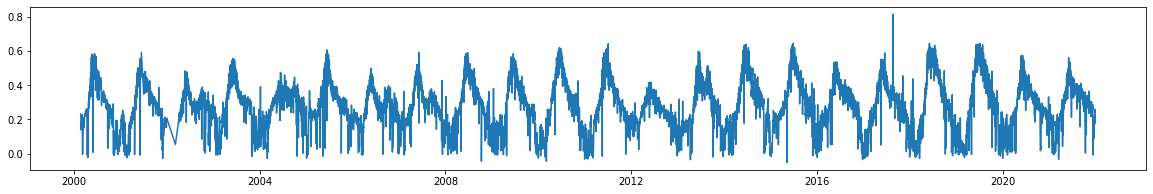

In [ ]:
plt.plot(NDVI_df)

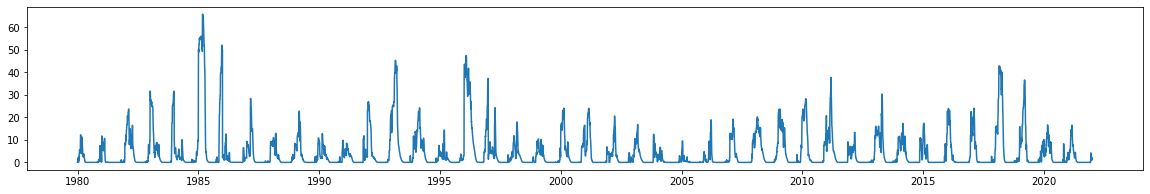

In [ ]:
plt.plot(swe_df)